In [1]:
import pandas as pd 
import matplotlib.pyplot as plt

import datetime
import numpy as np 

In [ ]:
string = datetime.datetime.today().strftime('%y%m%d') #fecha de base de datos
#string='210105'
path2 = 'C:/Users/Emilio EG/Documents/ITAM/CIC19/Reportes/'+string+'/'

hoy=datetime.datetime.today()
hoy= hoy - datetime.timedelta(days=1)
corte = hoy - datetime.timedelta(days=21) #hoy-12dias

base_covid = pd.read_csv(path2+string+'COVID19MEXICO'+'.csv',encoding='latin1') 
base_covid

In [ ]:
base_covid=base_covid[base_covid['CLASIFICACION_FINAL']==3] #positivo covid
base_cdmx=base_covid[base_covid['ENTIDAD_RES']==9] #de la CDMX
base_cdmx=base_cdmx[base_cdmx['MUNICIPIO_RES']!=999] #con alcaldia identificada
base_cdmx

In [ ]:
base_cdmx.loc[base_cdmx['FECHA_DEF'] == '9999-99-99', 'FECHA_DEF'] = pd.NaT #9999-99-99 pasa a ser NaT
base_cdmx['FECHA_DEF']=pd.to_datetime(base_cdmx['FECHA_DEF']) #los valores de la columna pasan a ser datetime
base_cdmx['FECHA_SINTOMAS']=pd.to_datetime(base_cdmx['FECHA_SINTOMAS']) #los valores de la columna pasan a ser datetime

base_def=base_cdmx.dropna() #eliminamos los NA, NaN y NaT
base_def

In [ ]:
delegacion=pd.read_excel('Delegaciones.xlsx')
delegacion

In [ ]:
defs={}
defs_tot={}
defs_avg={}

for i in range(0,16):
    defs[i]=base_def[base_def['MUNICIPIO_RES']==i+2].pivot_table(index=['FECHA_DEF'], aggfunc='size') #Contar muertes por dia en cada municipio
    defs[i]=pd.DataFrame(defs[i]) #lo anterior a dataframe
    idx=pd.date_range(defs[i].index[0],hoy) #creamos un indice de fechas desde el primer registro hasta hoy
    defs[i]=defs[i].reindex(idx, fill_value=0) #reindexamos el df para no saltarnos fechas
    defs_tot[i]=defs[i].cumsum()*(100000/delegacion['POBLACION'][i]) #el acumulado dia a dia por 100 mil habs
    defs_avg[i]=defs[i].rolling(window=7).mean()*(100000/delegacion['POBLACION'][i]) #defunciones diarias por 100 mil habs (promedio movil)

In [ ]:
con={}
con_tot={}
con_avg={}

for i in range(0,16):
    con[i]=base_cdmx[base_cdmx['MUNICIPIO_RES']==i+2].pivot_table(index=['FECHA_SINTOMAS'], aggfunc='size') #contar casos nuevos por dia
    con[i]=pd.DataFrame(con[i]) #lo anterior como dataframe
    idx=pd.date_range(con[i].index[0],hoy) #creamos un indice de fechas desde el primer registro hasta hoy
    con[i]=con[i].reindex(idx, fill_value=0) #reindexamos el df para no saltarnos fechas
    con_tot[i]=con[i].cumsum()*(100000/delegacion['POBLACION'][i]) #el acumulado dia a dia por 100 mil habs
    con_avg[i]=con[i].rolling(window=7).mean()*(100000/delegacion['POBLACION'][i]) #promedio movil de casos diarios por 100 mil habs

In [ ]:
def_dia=[] #cada valor de la serie corresponde a una delegacion, todas las delegaciones en la misma fecha
def_cum=[]
caso_dia=[]
caso_cum=[]

for i in range(len(delegacion)):
    def_dia.append(defs_avg[i].iloc[-13,-1]) #en la serie de defunciones diarias agregamos el valor hace 12 dias
    def_cum.append(defs_tot[i].iloc[-1,-1]) #en la serie de defunciones acumuladas agregamos el ultimo valor
    caso_dia.append(con_avg[i].iloc[-13,-1]) #en la serie de casos diarios agregamos el valor de hace 12 dias
    caso_cum.append(con_tot[i].iloc[-1,-1]) #en la serie de casos acumulados agregamos el ultimo valor

In [ ]:
delegacion['DEF_DIA']=def_dia
delegacion['DEF_CUM']=def_cum
delegacion['CASO_DIA']=caso_dia
delegacion['CASO_CUM']=caso_cum
    

In [ ]:
import geopandas as gpd

In [ ]:
shapefile = 'alcaldias.shp' #direccion del shp
gdf = gpd.read_file(shapefile)[['municipio','geometry']] #leemos el shp, solo las columnas municipio y geometry
gdf

In [ ]:
gdf['CLAVE_MUNICIPIO']=pd.DataFrame([9,14,5,2,6,10,13,17,12,4,15,7,3,16,8,11]) #creamos las claves de los municipios, sin esto no se puede juntar el geodataframe y el df
gdf

In [ ]:
gdf = gdf.merge(delegacion, left_on = 'CLAVE_MUNICIPIO', right_on = 'CLAVE_MUNICIPIO', how = 'left') #juntamos geodataframe y df
gdf

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable 
# import mapclassify 

fig, ax = plt.subplots(figsize = (15,11))
divider = make_axes_locatable(ax)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

import matplotlib as mpl

cmap = mpl.cm.Reds(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[5:,:-1])

# Defunciones diarias 

cax = divider.append_axes('bottom', size = '5%', pad = 0.1)
cax.tick_params(labelsize=15)

gdf.apply(lambda x: ax.annotate(s=x.CLAVE_MUNICIPIO, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

gdf.plot(column = 'DEF_DIA', ax = ax, cax = cax, cmap = cmap, legend = True, legend_kwds={'orientation':'horizontal'})
plt.title('Defunciones diarias por 100 mil habs.\n',fontsize=20)
plt.savefig(path2 + 'cdmx-def-diarias.png', bbox_inches='tight')
plt.show()
plt.clf()

In [ ]:
fig, ax = plt.subplots(figsize = (15,11))
divider = make_axes_locatable(ax)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

import matplotlib as mpl

cmap = mpl.cm.Reds(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[5:,:-1])

# Defunciones diarias 

cax = divider.append_axes('bottom', size = '5%', pad = 0.1)
cax.tick_params(labelsize=15)

gdf.apply(lambda x: ax.annotate(s=x.CLAVE_MUNICIPIO, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

gdf.plot(column = 'DEF_CUM', ax = ax, cax = cax, cmap = cmap, legend = True, legend_kwds={'orientation':'horizontal'})
plt.title('Defunciones acumuladas por 100 mil habs.\n',fontsize=20)
plt.savefig(path2 + 'cdmx-def-acum.png', bbox_inches='tight')
plt.show()
plt.clf()

In [ ]:
fig, ax = plt.subplots(figsize = (15,11))
divider = make_axes_locatable(ax)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

import matplotlib as mpl

cmap = mpl.cm.Reds(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[5:,:-1])

# Defunciones diarias 

cax = divider.append_axes('bottom', size = '5%', pad = 0.1)
cax.tick_params(labelsize=15)

gdf.apply(lambda x: ax.annotate(s=x.CLAVE_MUNICIPIO, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

gdf.plot(column = 'CASO_DIA', ax = ax, cax = cax, cmap = cmap, legend = True, legend_kwds={'orientation':'horizontal'})
plt.title('Contagios diarios por 100 mil habs.\n',fontsize=20)
plt.savefig(path2 + 'cdmx-casos-dia.png', bbox_inches='tight')
plt.show()
plt.clf()

In [ ]:
fig, ax = plt.subplots(figsize = (15,11))
divider = make_axes_locatable(ax)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

import matplotlib as mpl

cmap = mpl.cm.Reds(np.linspace(0,1,20))
cmap = mpl.colors.ListedColormap(cmap[5:,:-1])

# Defunciones diarias 

cax = divider.append_axes('bottom', size = '5%', pad = 0.1)
cax.tick_params(labelsize=15)

gdf.apply(lambda x: ax.annotate(s=x.CLAVE_MUNICIPIO, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

gdf.plot(column = 'CASO_CUM', ax = ax, cax = cax, cmap = cmap, legend = True, legend_kwds={'orientation':'horizontal'})
plt.title('Contagios acumulados por 100 mil habs.\n',fontsize=20)
plt.savefig(path2+'cdmx-casos-acum.png', bbox_inches='tight')
plt.show()
plt.clf()

# REGISTRO CIVIL VS COVID

In [ ]:
corte=datetime.datetime(2020,9,20)
corte

In [19]:
muertes_cdmx = base_def.pivot_table(index=['FECHA_DEF'], aggfunc='size') #contamos muertes por dia en toda la CDMX
muertes_cdmx = pd.DataFrame(muertes_cdmx) #lo anterior como df
idx = pd.date_range(muertes_cdmx.index[0],hoy) #indice desde la fecha del primer dato hasta hoy
muertes_cdmx = muertes_cdmx.reindex(idx, fill_value=0) #reindexamos para que no falten fechas
muertes_cdmx.head(21)

,0
2020-03-22,1
2020-03-23,1
2020-03-24,0
2020-03-25,1
2020-03-26,3
2020-03-27,4
2020-03-28,1
2020-03-29,2
2020-03-30,4
2020-03-31,7


In [21]:
lunes=pd.date_range('2020-03-08',corte,freq='W') #intervalo de cada lunes desde el 1 de marzo
lunes

DatetimeIndex(['2020-03-08', '2020-03-15', '2020-03-22', '2020-03-29',
               '2020-04-05', '2020-04-12', '2020-04-19', '2020-04-26',
               '2020-05-03', '2020-05-10', '2020-05-17', '2020-05-24',
               '2020-05-31', '2020-06-07', '2020-06-14', '2020-06-21',
               '2020-06-28', '2020-07-05', '2020-07-12', '2020-07-19',
               '2020-07-26', '2020-08-02', '2020-08-09', '2020-08-16',
               '2020-08-23', '2020-08-30', '2020-09-06', '2020-09-13',
               '2020-09-20'],
              dtype='datetime64[ns]', freq='W-SUN')

In [22]:
covideath=muertes_cdmx.rolling(7).sum().loc[lunes] #sumamos las muertes de los ultimos 7 dias, y solo nos quedamos con las de los lunes
covideath['covid_cum']=covideath.cumsum()
covideath

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,0,covid_cum
2020-03-08,NaN,NaN
2020-03-15,NaN,NaN
2020-03-22,NaN,NaN
2020-03-29,12.0,12.0
2020-04-05,38.0,50.0
2020-04-12,107.0,157.0
2020-04-19,159.0,316.0
2020-04-26,309.0,625.0
2020-05-03,431.0,1056.0
2020-05-10,539.0,1595.0


In [23]:
weeks = pd.read_excel('weeks.xlsx', index_col=0)
weeks = weeks.loc[lunes]
#weeks['mean_cum'] = weeks['media_ajustada'].cumsum()
#weeks['2019_ajust'] = weeks[2019]*1.0173
#weeks['19_accum'] = weeks['2019-accum']*1.0173
weeks['diff-mean-cum'] = weeks['2020-accum']-weeks['accum18-20']
#weeks['diff-19-cum'] = weeks['2020-accum']-weeks['2019-accum']*1.0173
weeks['diff-mean'] = weeks[2020]-weeks['ajuste18-20']
#weeks['diff-19'] = weeks[2020]-weeks[2019]*1.0173
weeks 

,week,2016,2017,2018,2019,2020,2019-accum,2020-accum,promedio18,ajuste18-20,accum18-20,promedio19,media_ajustada,suma16-18,acum16-18,accum16-19,prom-accum,diff-mean-cum,diff-mean
2020-03-08,10,1617,1637,1410,1497,1430,16610,16164,1554.666667,1608.923430,17260.740291,1540.25,1566.896325,4664,50036,66646.0,16949.743950,-1096.740291,-178.923430
2020-03-15,11,1617,1665,1457,1496,1550,18106,17714,1579.666667,1634.795912,18895.536203,1558.75,1585.716375,4739,54775,72881.0,18535.460325,-1181.536203,-84.795912
2020-03-22,12,1377,1552,1393,1484,1407,19590,19121,1440.666667,1490.944910,20386.481114,1451.50,1476.610950,4322,59097,78687.0,20012.071275,-1265.481114,-83.944910
2020-03-29,13,1380,1545,1350,1519,1499,21109,20620,1425.000000,1474.731488,21861.212602,1448.50,1473.559050,4275,63372,84481.0,21485.630325,-1241.212602,24.268512
2020-04-05,14,1457,1534,1415,1465,1491,22574,22111,1468.666667,1519.922091,23381.134693,1467.75,1493.142075,4406,67778,90352.0,22978.772400,-1270.134693,-28.922091
2020-04-12,15,1387,1385,1403,1490,1624,24064,23735,1391.666667,1440.234845,24821.369538,1416.25,1440.751125,4175,71953,96017.0,24419.523525,-1086.369538,183.765155
2020-04-19,16,1330,1390,1357,1468,1828,25532,25563,1359.000000,1406.428135,26227.797673,1386.25,1410.232125,4077,76030,101562.0,25829.755650,-664.797673,421.571865
2020-04-26,17,1314,1455,1377,1377,2475,26909,28038,1382.000000,1430.230819,27658.028492,1380.75,1404.636975,4146,80176,107085.0,27234.392625,379.971508,1044.769181
2020-05-03,18,1376,1372,1389,1379,3508,28288,31546,1379.000000,1427.126121,29085.154613,1379.00,1402.856700,4137,84313,112601.0,28637.249325,2460.845387,2080.873879
2020-05-10,19,1324,1434,1401,1463,4127,29751,35673,1386.333333,1434.715382,30519.869995,1405.50,1429.815150,4159,88472,118223.0,30067.064475,5153.130005,2692.284618


In [17]:
weeks.to_csv('muertesextraCDMX.csv')

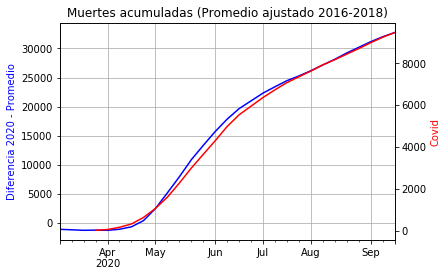

In [24]:
plt.figure()

ax1 = weeks['diff-mean-cum'].plot(color='blue', grid=True, label='Diferencia 2020-promedio')
ax2 = covideath['covid_cum'].plot(color='red', grid=True, secondary_y=True, label='Covid')

ax1.set_ylabel('Diferencia 2020 - Promedio',color='blue')
ax2.set_ylabel('Covid',color='red')

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()

plt.title('Muertes acumuladas (Promedio ajustado 2016-2018)')
#plt.legend(h1+h2, l1+l2, loc=2)
plt.savefig('muertes-acumuladas-promedio18.png',bbox_inches='tight')
plt.show()

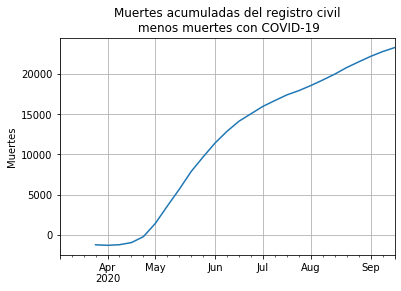

In [25]:
(weeks['diff-mean-cum']-covideath['covid_cum']).plot(grid=True, label='Muertes acumuladas covid no registradas')
plt.title('Muertes acumuladas del registro civil\n menos muertes con COVID-19')
plt.ylabel('Muertes')
plt.savefig('muertes-acumuladas-extra1820.png',bbox_inches='tight')
plt.show()

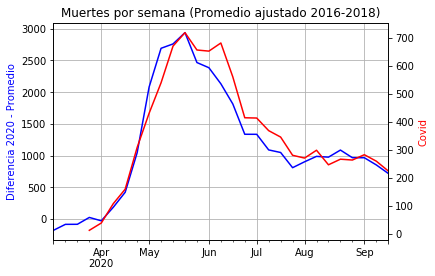

In [26]:
plt.figure()

ax1 = weeks['diff-mean'].plot(color='blue', grid=True, label='Diferencia 2020-promedio')
ax2 = covideath[0].plot(color='red', grid=True, secondary_y=True, label='Covid')

ax1.set_ylabel('Diferencia 2020 - Promedio',color='blue')
ax2.set_ylabel('Covid',color='red')

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()

plt.title('Muertes por semana (Promedio ajustado 2016-2018)')
#plt.legend(h1+h2, l1+l2, loc=2)
plt.savefig('muertes_semana-promedio18.png',bbox_inches='tight')
plt.show()

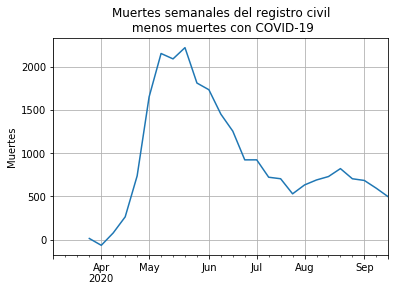

In [27]:
(weeks['diff-mean']-covideath[0]).plot(grid=True, label='Muertes semanales covid no registradas')
plt.title('Muertes semanales del registro civil\n menos muertes con COVID-19')
plt.ylabel('Muertes')
plt.savefig('muertes-semana-extra1820.png',bbox_inches='tight')
plt.show()

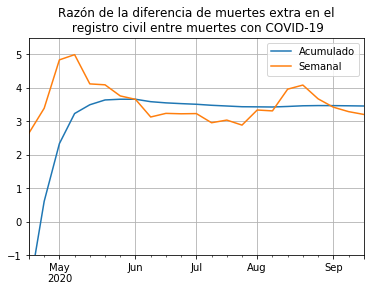

In [28]:
ratio_mean_acum = weeks['diff-mean-cum']/covideath['covid_cum']
ratio_mean = weeks['diff-mean']/covideath[0]

ratio_mean_acum.plot(label='Acumulado')
ratio_mean.plot(label='Semanal', grid=True)
plt.title('Razón de la diferencia de muertes extra en el\n registro civil entre muertes con COVID-19')
plt.legend()
plt.xlim('2020-04-19',corte)
plt.ylim(-1,5.5)
plt.savefig('ratio-mean1820.png',bbox_inches='tight')
plt.show()

In [22]:
ratio_mean_acum

2020-03-08           NaN
2020-03-15           NaN
2020-03-22           NaN
2020-03-29   -103.434383
2020-04-05    -25.402694
2020-04-12     -6.919551
2020-04-19     -2.103790
2020-04-26      0.608929
2020-05-03      2.334768
2020-05-10      3.234859
2020-05-17      3.497129
2020-05-24      3.640725
2020-05-31      3.662464
2020-06-07      3.661969
2020-06-14      3.589256
2020-06-21      3.553856
2020-06-28      3.531105
2020-07-05      3.511766
2020-07-12      3.481556
2020-07-19      3.459969
2020-07-26      3.438222
2020-08-02      3.434755
2020-08-09      3.430200
2020-08-16      3.446272
2020-08-23      3.466452
2020-08-30      3.472741
2020-09-06      3.471240
2020-09-13      3.466216
2020-09-20      3.460104
Freq: W-SUN, dtype: float64

In [29]:
from docx import Document
from docx.shared import Inches

In [33]:
document = Document()
document.add_heading('Comparación de defunciones en el Registro Civil y por COVID-19 21-10-2020',0)

document.add_picture('muertes-acumuladas-promedio18.png', width=Inches(4.5))
document.add_picture('muertes-acumuladas-extra1820.png', width=Inches(4.5))


document.add_picture('muertes_semana-promedio18.png', width=Inches(4.5))
document.add_picture('muertes-semana-extra1820.png', width=Inches(4.5))

document.add_picture('ratio-mean1820.png', width=Inches(4.5))

document.save('Diferencia en el registro de defunciones al 21-10-2020.docx')  

# YA NO SE USA

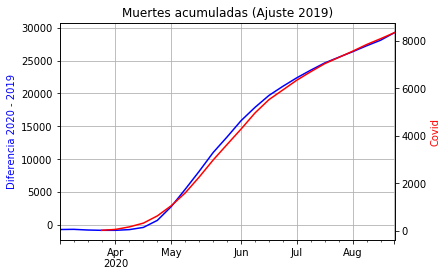

In [17]:
plt.figure()

ax1 = weeks['diff-19-cum'].plot(color='blue', grid=True, label='Diferencia 2020 - 2019')
ax2 = covideath['covid_cum'].plot(color='red', grid=True, secondary_y=True, label='Covid')

ax1.set_ylabel('Diferencia 2020 - 2019',color='blue')
ax2.set_ylabel('Covid',color='red')

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()

plt.title('Muertes acumuladas (Ajuste 2019)')
#plt.legend(h1+h2, l1+l2, loc=2)
plt.savefig('muertes_acumuladas-2019.png',bbox_inches='tight')
plt.show()

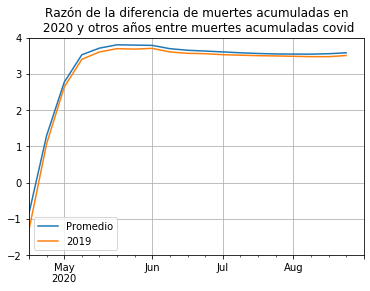

In [18]:
ratio_mean_acum = weeks['diff-mean-cum']/covideath['covid_cum']
ratio_19_acum = weeks['diff-19-cum']/covideath['covid_cum']

ratio_mean_acum.plot(label='Promedio')
ratio_19_acum.plot(label='2019', grid=True)
plt.title('Razón de la diferencia de muertes acumuladas en\n 2020 y otros años entre muertes acumuladas covid')
plt.legend()
plt.xlim('2020-04-19',corte)
plt.ylim(-2,4)
plt.savefig('ratio-accum.png',bbox_inches='tight')
plt.show()

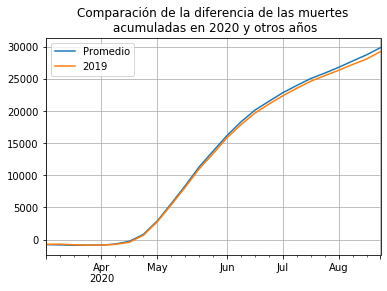

In [19]:
weeks['diff-mean-cum'].plot(label='Promedio')
weeks['diff-19-cum'].plot(label='2019', grid=True)
plt.title('Comparación de la diferencia de las muertes\n acumuladas en 2020 y otros años')
plt.legend()
#plt.xlim('2020-04-19',corte)
#plt.ylim(-2,4)
plt.savefig('comp-accum.png',bbox_inches='tight')
plt.show()

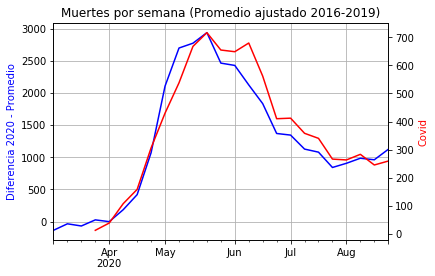

In [17]:
plt.figure()

ax1 = weeks['diff-mean'].plot(color='blue', grid=True, label='Diferencia 2020-promedio')
ax2 = covideath[0].plot(color='red', grid=True, secondary_y=True, label='Covid')

ax1.set_ylabel('Diferencia 2020 - Promedio',color='blue')
ax2.set_ylabel('Covid',color='red')

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()

plt.title('Muertes por semana (Promedio ajustado 2016-2019)')
#plt.legend(h1+h2, l1+l2, loc=2)
plt.savefig('muertes_semana-promedio.png',bbox_inches='tight')
plt.show()

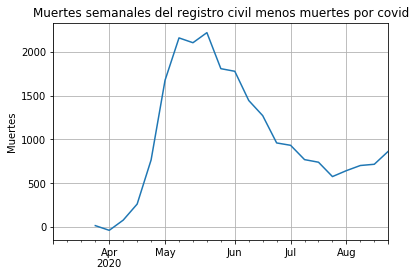

In [18]:
(weeks['diff-mean']-covideath[0]).plot(grid=True, label='Muertes semanales covid no registradas')
plt.title('Muertes semanales del registro civil menos muertes por covid')
plt.ylabel('Muertes')
plt.savefig('muertes-semana-extra.png',bbox_inches='tight')
plt.show()

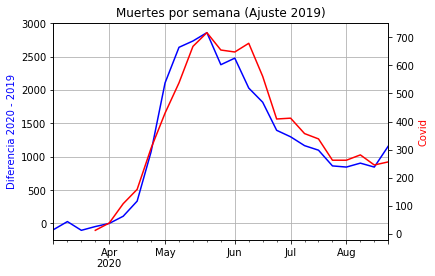

In [22]:
plt.figure()

ax1 = weeks['diff-19'].plot(color='blue', grid=True, label='Diferencia 2020-Diferencia 2020 - 2019')
ax2 = covideath[0].plot(color='red', grid=True, secondary_y=True, label='Covid')

ax1.set_ylabel('Diferencia 2020 - 2019',color='blue')
ax2.set_ylabel('Covid',color='red')

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()

plt.title('Muertes por semana (Ajuste 2019)')
#plt.legend(h1+h2, l1+l2, loc=2)
plt.savefig('muertes_semana-2019.png',bbox_inches='tight')
plt.show()

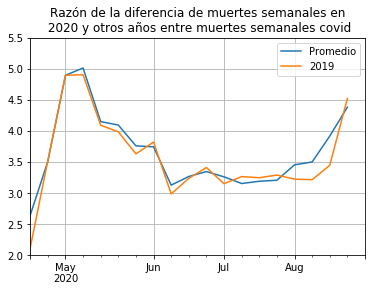

In [23]:
ratio_mean = weeks['diff-mean']/covideath[0]
ratio_19 = weeks['diff-19']/covideath[0]

ratio_mean.plot(label='Promedio')
ratio_19.plot(label='2019', grid=True)
plt.title('Razón de la diferencia de muertes semanales en\n 2020 y otros años entre muertes semanales covid')
plt.legend()
plt.xlim('2020-04-19',corte)
plt.ylim(2,5.5)
plt.savefig('ratio-sem.png',bbox_inches='tight')
plt.show()

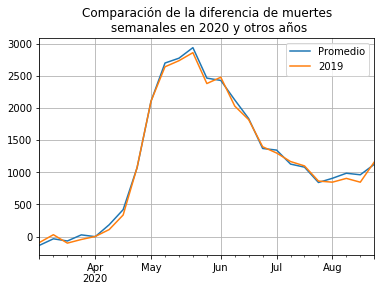

In [24]:
weeks['diff-mean'].plot(label='Promedio')
weeks['diff-19'].plot(label='2019', grid=True)
plt.title('Comparación de la diferencia de muertes\n semanales en 2020 y otros años')
plt.legend()
#plt.xlim('2020-04-19',corte)
#plt.ylim(2,5.5)
plt.savefig('comp-sem.png',bbox_inches='tight')
plt.show()

In [26]:
from docx import Document
from docx.shared import Inches

In [27]:
document = Document()
document.add_heading('Comparación de defunciones en el Registro Civil y por COVID-19',0)

document.add_picture('muertes-acumuladas-promedio.png', width=Inches(4.5))
#document.add_picture('muertes_acumuladas-2019.png', width=Inches(4.5))
document.add_picture('muertes-acumuladas-extra.png', width=Inches(4.5))


document.add_picture('muertes_semana-promedio.png', width=Inches(4.5))
#document.add_picture('muertes_semana-2019.png', width=Inches(4.5))
document.add_picture('muertes-semana-extra.png', width=Inches(4.5))


#document.add_picture('comp-accum.png', width=Inches(4.5))
#document.add_picture('comp-sem.png', width=Inches(4.5))

#document.add_picture('ratio-accum.png', width=Inches(4.5))
#document.add_picture('ratio-sem.png', width=Inches(4.5))


document.save('Comparacion de defunciones.docx')  

# YA NO SE USA

In [22]:
weeks = pd.read_excel('weeks-2020.xlsx')

# cambiamos el formato a string para cambiar abr a apr y ago a aug, para poder usar datetime
# además agregamos el 2020. Lo hacemos de la columna 2 a la 23 porque en las últimas cambia el formato

weeks.iloc[0,2:23] = weeks.iloc[0,2:23].astype('str')
weeks.iloc[0,2:23] = weeks.iloc[0,2:23].apply(lambda x: x.replace('abr','apr'))
weeks.iloc[0,2:23] = weeks.iloc[0,2:23].apply(lambda x: x.replace('ago','aug'))
weeks.iloc[0,2:23] = weeks.iloc[0,2:23].apply(lambda x: x + '-2020')
# pasamos al otro formato y eliminamos el tiempo
weeks.iloc[0,23:26] = weeks.iloc[0,23:26].astype('str').apply(lambda x: x.replace( ' 00:00:00',''))


#### NOTA: están divididas en dos porque tienen diferentes formatos por alguna extraña razón

# Les cambiamos el formato para que sea igual al de la base covid (otro programa)
p = weeks.iloc[0,2:23].apply(lambda x: datetime.datetime.strptime(x,'%d-%b-%Y')) # pasamos a datetime la primera parte
weeks.iloc[0,2:23] = p.apply(lambda x: datetime.datetime.strftime(x,'%Y-%m-%d'))

u = weeks.iloc[0,23:26].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d')) # pasamos a datetime la ultima parte 
weeks.iloc[0,23:26] = u.apply(lambda x: datetime.datetime.strftime(x,'%Y-%m-%d'))

# La transponemos porque me da paz mental 
weeks = weeks.T
weeks.iloc[1,0] = 'FECHA_DEF'

weeks = weeks.drop(index = 'Unnamed: 0') # Quitamos el primer renglon 
weeks.columns = weeks.iloc[0] # Nombramos las columnas como el primer renglón 
weeks = weeks.drop(index = 'Week') # Borramos el primer renglón (porque ya lo tenemos como header que es lo que queríamos)

###### NO QUITEN LA COLUMNA 0, TIENE VALORES MÁS ABAJO 

weeks

Week,FECHA_DEF,0,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,50,51,52,Total
9,2020-03-01,NaN,0,25,158,22,10,0,86,0,...,36,0,0,4,222,63,115,2242,0,14734
10,2020-03-08,NaN,0,28,175,23,10,0,98,0,...,38,0,0,5,245,70,123,2479,0,16164
11,2020-03-15,0,0,30,193,25,10,0,109,0,...,41,0,0,7,265,77,132,2739,0,17713
12,2020-03-22,NaN,0,31,215,25,10,0,120,0,...,48,0,0,7,292,84,139,2968,0,19121
13,2020-03-29,NaN,0,31,215,25,10,0,120,0,...,48,0,0,7,292,84,139,3358,0,20620
14,2020-04-05,NaN,0,31,215,25,10,0,120,0,...,48,0,0,7,292,84,139,3781,0,22111
15,2020-04-12,NaN,0,31,215,25,10,0,120,0,...,48,0,0,7,292,84,139,4255,0,23735
16,2020-04-19,NaN,0,31,215,25,10,0,120,0,...,48,0,0,7,292,84,139,4796,0,25563
17,2020-04-26,39,0,31,215,25,10,0,120,0,...,48,0,0,7,292,84,139,5592,0,28038
18,2020-05-03,97,0,31,215,25,10,0,120,0,...,48,0,0,7,292,84,139,6897,0,31546


In [23]:
ripinri = weeks.set_index('FECHA_DEF')
ripinri.index = pd.to_datetime(ripinri.index)
ripinri.index

DatetimeIndex(['2020-03-01', '2020-03-08', '2020-03-15', '2020-03-22',
               '2020-03-29', '2020-04-05', '2020-04-12', '2020-04-19',
               '2020-04-26', '2020-05-03', '2020-05-10', '2020-05-17',
               '2020-05-24', '2020-05-31', '2020-06-07', '2020-06-14',
               '2020-06-21', '2020-06-28', '2020-07-05', '2020-07-12',
               '2020-07-19', '2020-07-26', '2020-08-02', '2020-08-09'],
              dtype='datetime64[ns]', name='FECHA_DEF', freq=None)

In [24]:
ripinri['muerte_sem']=0

for i in range(1,len(ripinri)):
    ripinri['muerte_sem'][i]=ripinri['Total'][i]-ripinri['Total'][i-1]
    
ripinri

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Week,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,Total,muerte_sem
FECHA_DEF,,,,,,,,,,,,,,,,,,,,,
2020-03-01,NaN,0,25,158,22,10,0,86,0,31,...,0,0,4,222,63,115,2242,0,14734,0
2020-03-08,NaN,0,28,175,23,10,0,98,0,35,...,0,0,5,245,70,123,2479,0,16164,1430
2020-03-15,0,0,30,193,25,10,0,109,0,39,...,0,0,7,265,77,132,2739,0,17713,1549
2020-03-22,NaN,0,31,215,25,10,0,120,0,47,...,0,0,7,292,84,139,2968,0,19121,1408
2020-03-29,NaN,0,31,215,25,10,0,120,0,47,...,0,0,7,292,84,139,3358,0,20620,1499
2020-04-05,NaN,0,31,215,25,10,0,120,0,47,...,0,0,7,292,84,139,3781,0,22111,1491
2020-04-12,NaN,0,31,215,25,10,0,120,0,47,...,0,0,7,292,84,139,4255,0,23735,1624
2020-04-19,NaN,0,31,215,25,10,0,120,0,47,...,0,0,7,292,84,139,4796,0,25563,1828
2020-04-26,39,0,31,215,25,10,0,120,0,47,...,0,0,7,292,84,139,5592,0,28038,2475


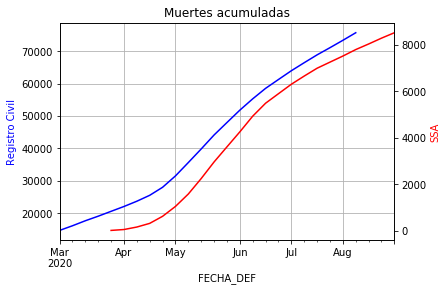

In [25]:
plt.figure()

ax1 = ripinri['Total'].plot(color='blue', grid=True, label='Registro Civil')
ax2 = covideath['covid_cum'].plot(color='red', grid=True, secondary_y=True, label='Covid SSA')

ax1.set_ylabel('Registro Civil',color='blue')
ax2.set_ylabel('SSA',color='red')

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()

plt.title('Muertes acumuladas')
#plt.legend(h1+h2, l1+l2, loc=2)
plt.savefig('comparacion_muertes_acumuladas.png',bbox_inches='tight')
plt.show()

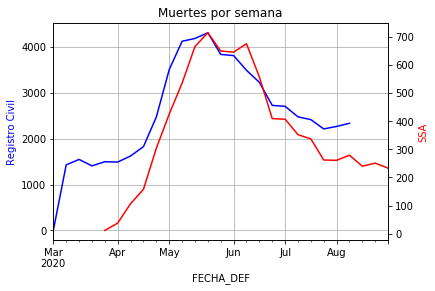

In [26]:
plt.figure()

ax1 = ripinri['muerte_sem'].plot(color='blue', grid=True, label='Registro Civil')
ax2 = covideath[0].plot(color='red', grid=True, secondary_y=True, label='Covid SSA')

ax1.set_ylabel('Registro Civil',color='blue')
ax2.set_ylabel('SSA',color='red')

#h1, l1 = ax1.get_legend_handles_labels()
#h2, l2 = ax2.get_legend_handles_labels()

plt.title('Muertes por semana')
#plt.legend(h1+h2, l1+l2, loc=2)
plt.savefig('comparacion_muertes_semanales.png',bbox_inches='tight')
plt.show()